# Building a Baseline Model for MBTI Predictions

## 1) Data Preparation 


### 1.1) What is our dataset?

Our dataset that we will be utilizing for this baseline model is the 'Types 500' MBTI dataset,'(MBTI) Myers-Briggs Personality Type Dataset', and the 'MBTI Personality Type Twitter Dataset' from Kaggle.

For this baseline, we will only use the 'Types 500' as it has already been lightly preproccessed.

In [1]:
import pandas as pd

data = pd.read_csv("Types500.csv")
data.head()

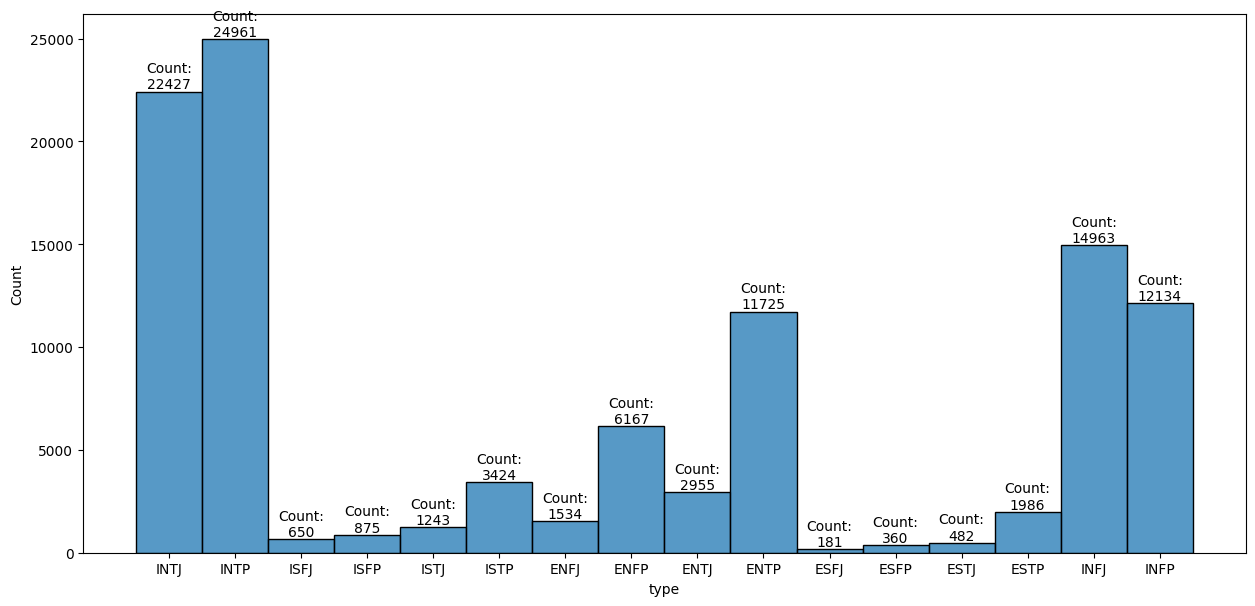

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

## Make a Plot
ax = plt.subplot()

## Histogram for Quick Barplot with Counts on Top
sns.histplot(data.type);
ax.bar_label(ax.containers[1], fmt = 'Count:\n%.0f', label_type='edge');
ax.figure.set_figwidth(15);
ax.figure.set_figheight(7);

###  1.2) How common are the types according to the MBTI Foundation

The MBTI Foundation has taken 30 years of research to determine the expected  personality types. 

-----
I - 50.7%
 
E - 49.3%
 
N - 26.7%
 
S - 73.3%
 
T - 40.2%
 
F - 59.8%

P - 45.9%
 
J - 54.1%

Let's see how our own dataframe compares

In [4]:
## This should make columns of binary targets
data['e_i'] = data['type'].astype(str).str[0]
data['s_n'] = data['type'].astype(str).str[1]
data['f_t'] = data['type'].astype(str).str[2]
data['p_j'] = data['type'].astype(str).str[3]

## This should be the percentages of each class
diff_ei = (data['e_i'].value_counts() / data['e_i'].count())
diff_sn = (data['s_n'].value_counts() / data['s_n'].count()) 
diff_ft = (data['f_t'].value_counts() / data['f_t'].count())
diff_pj = (data['p_j'].value_counts() / data['p_j'].count())

diff_data = pd.concat([diff_ei, diff_sn, diff_ft, diff_pj])

## Printing the Percentage of Each Class in Binary
for column, val in diff_data.items():
    print(f"{column} is {round(val*100,2)}%")

I is 76.06%
E is 23.94%
N is 91.33%
S is 8.67%
T is 65.24%
F is 34.76%
P is 58.11%
J is 41.89%


Not so close to reality

## 2) Model for 16 Classes of MBTI

We will first try to create models that can predict the 16 types of MBTI personalities. 

Our F1-Score, which is the average of the precision and recall, will be our main metric for scoring considering our unbalanced datesets.



### 2.1) Setting X and y, training and testing
We must define X and y

In [78]:
X = data['posts']
y = data['type']

In [84]:
from sklearn.model_selection import train_test_split

## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.3,
                                                    random_state=1)

### 2.1) Multinomial Naive-Bayes Model with No Parameters

Simple vectorization, then using Multinomial NB to make a model that we can cross validate

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict


## Fitting a Model (of our choice) by function
def BaselineModel(X_train, X_test, y_train, model_selection):
    count_vectorizer = CountVectorizer()
    X_bow_train = count_vectorizer.fit_transform(X_train)
    X_bow_test = count_vectorizer.fit_transform(X_test)

    model_nb = model_selection

    model_nb.fit(X_bow_train, y_train)
    
    return model_nb, X_bow_test

model, X_bow_test = BaselineModel(X_train, X_test, y_train, MultinomialNB())

Let's see our results!

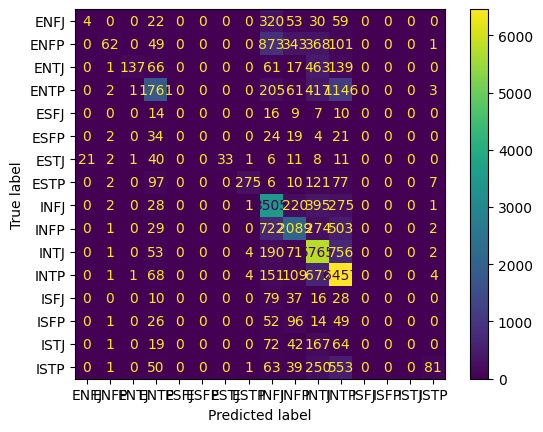

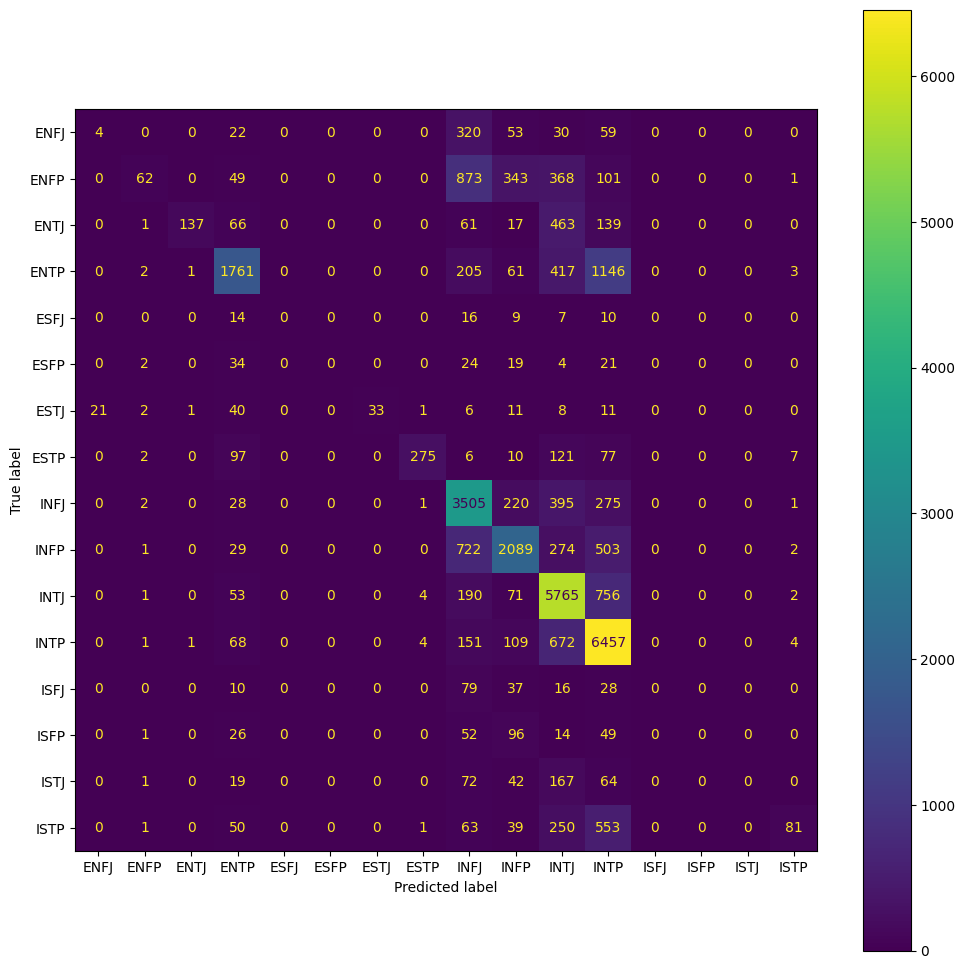

/home/aforbesj/.pyenv/versions/3.10.6/envs/post2personality/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        ENFJ       0.16      0.01      0.02       488
        ENFP       0.78      0.03      0.07      1797
        ENTJ       0.98      0.15      0.27       884
        ENTP       0.74      0.49      0.59      3596
        ESFJ       0.00      0.00      0.00        56
        ESFP       0.00      0.00      0.00       104
        ESTJ       1.00      0.25      0.40       134
        ESTP       0.96      0.46      0.62       595
        INFJ       0.55      0.79      0.65      4427
        INFP       0.65      0.58      0.61      3620
        INTJ       0.64      0.84      0.73      6842
        INTP       0.63      0.86      0.73      7467
        ISFJ       0.00      0.00      0.00       170
        ISFP       0.00      0.00      0.00       238
        ISTJ       0.00      0.00      0.00       365
        ISTP       0.80      0.08      0.14      1038

    accuracy                           0.63     31821
   macro avg       0.49   

/home/aforbesj/.pyenv/versions/3.10.6/envs/post2personality/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aforbesj/.pyenv/versions/3.10.6/envs/post2personality/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


## Showcasing results in an intuitive and also a quantitative way
def BaselinePrediction(model, X_bow_test, y_test):
    y_pred = cross_val_predict(model_nb, X_bow_test, y_test, cv = 10)

    confusion = confusion_matrix(y_test, y_pred)
    cmp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(10,10))
    plt.tight_layout()
    cmp.plot(ax=ax)
    plt.show()
    print(classification_report(y_test, y_pred))
    
BaselinePrediction(model = model, X_bow_test = X_bow_test, y_test = y_test)

## Baseline Score for 16 Class Model Approach:
# 30% F1

## 3) Models for Binary Classification
Essentially remaking the model with binary classification in mind between the binary aspects of MBTI. 

In [184]:
## Call our previous funcitons but have the target be Binary
def BaselineBinary(Column):
    """
    Input the Column from the DataFrame as a string for binary modelling.
    Outputs prints of the Confusion Matrix and the Classification Report.
    """
    y_set = data[Column]
    X_set = data['posts']
    
    X_train, X_test, y_train, y_test = train_test_split(X_set,y_set,
                                                    test_size=.3,
                                                    random_state=1) 
    
    model, X_bow_test = BaselineModel(X_train = X_train, 
                                      X_test = X_test, 
                                      y_train = y_train, 
                                      model_selection = MultinomialNB())
    BaselinePrediction(model = model, 
                       X_bow_test = X_bow_test, 
                       y_test = y_test)
    

### 3.1) Extrovert VS Introvert

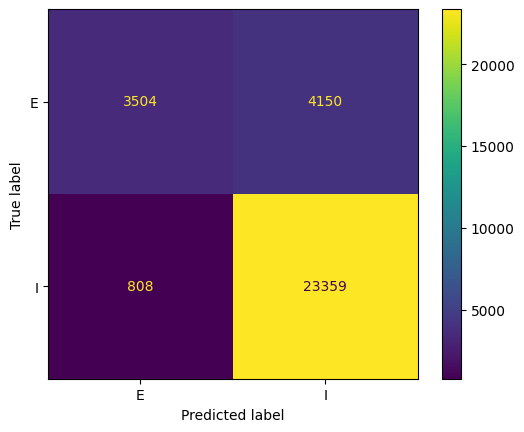

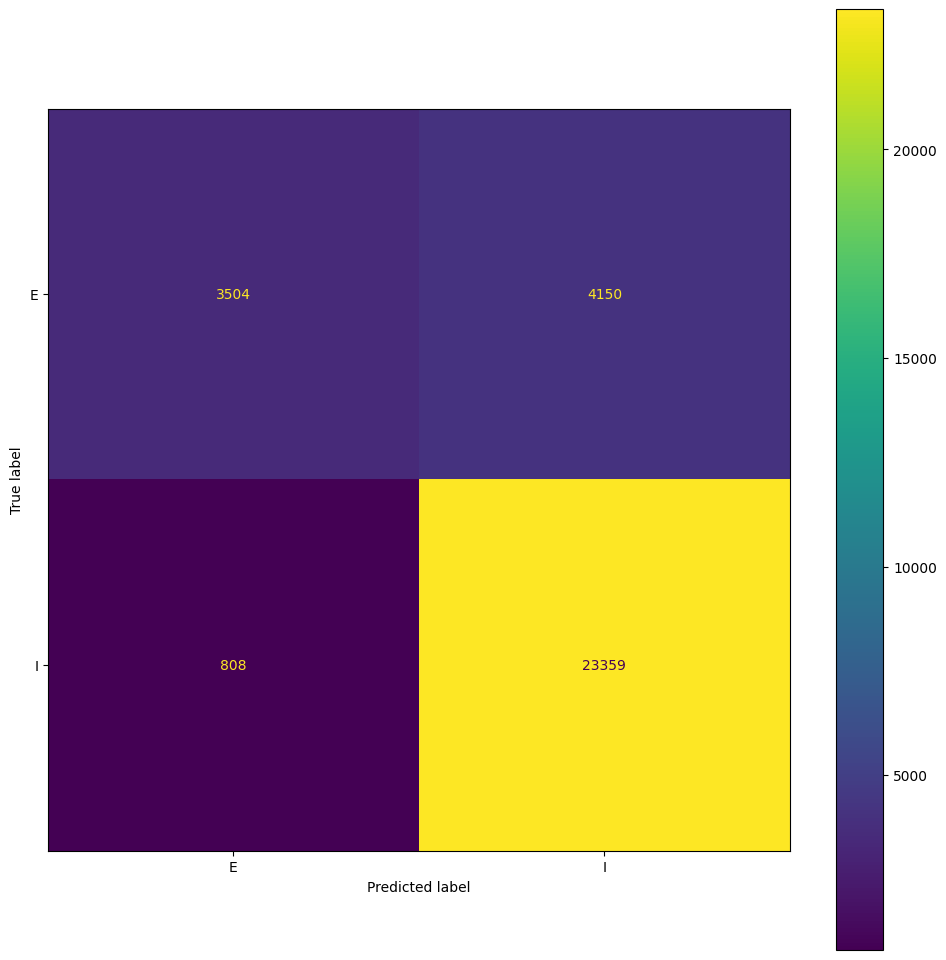

              precision    recall  f1-score   support

           E       0.81      0.46      0.59      7654
           I       0.85      0.97      0.90     24167

    accuracy                           0.84     31821
   macro avg       0.83      0.71      0.74     31821
weighted avg       0.84      0.84      0.83     31821



In [172]:
BaselineBinary('e_i')

### 3.2) Sensing VS INtuition

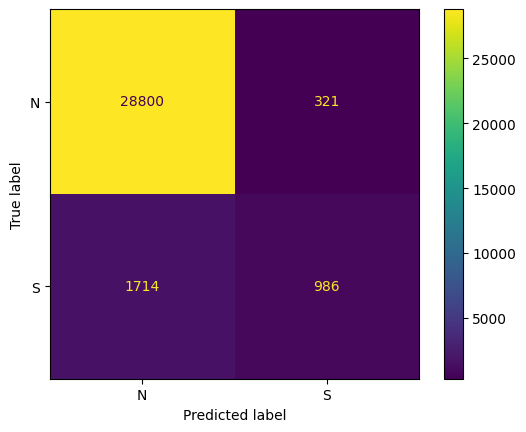

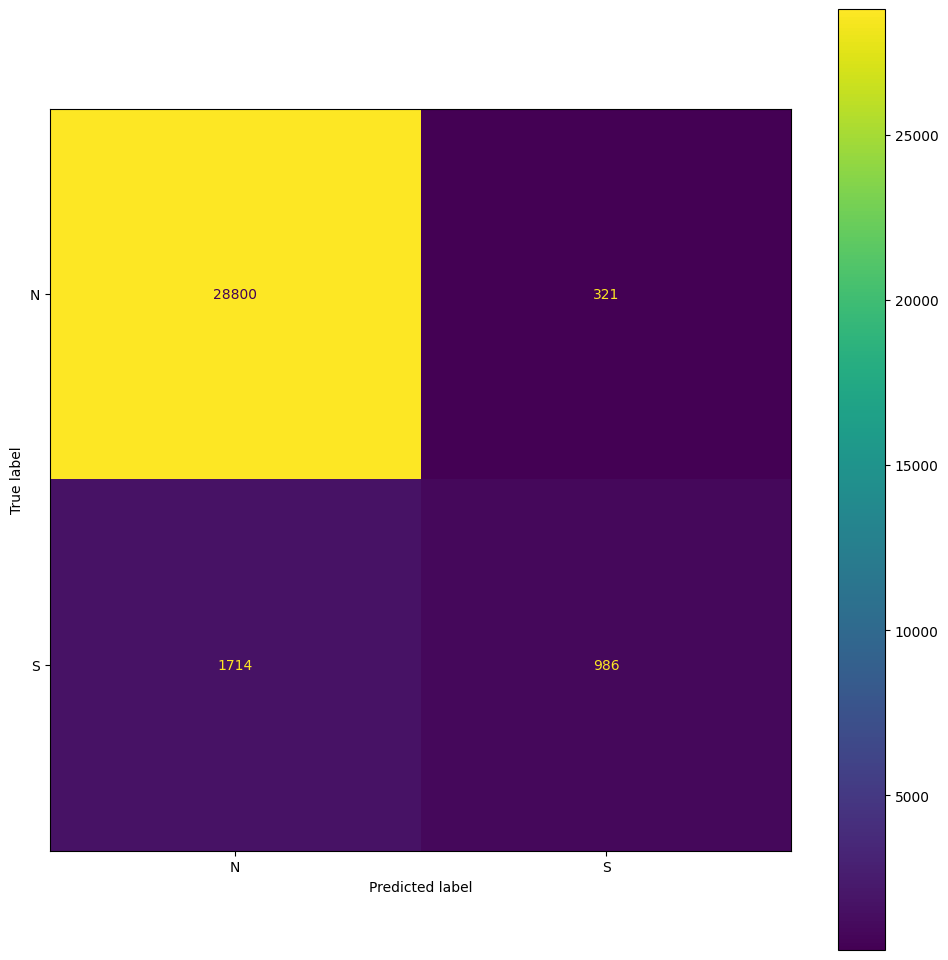

              precision    recall  f1-score   support

           N       0.94      0.99      0.97     29121
           S       0.75      0.37      0.49      2700

    accuracy                           0.94     31821
   macro avg       0.85      0.68      0.73     31821
weighted avg       0.93      0.94      0.93     31821



In [173]:
BaselineBinary('s_n')

### 3.3) Thinking VS Feeling

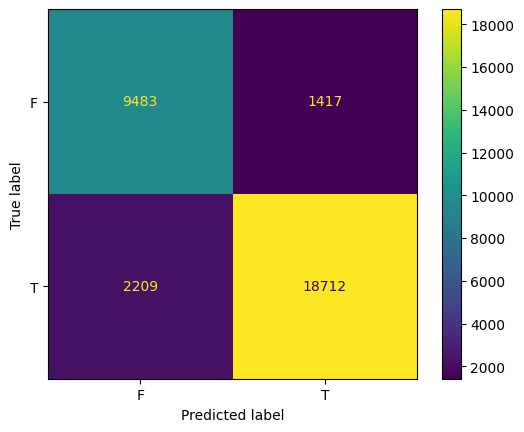

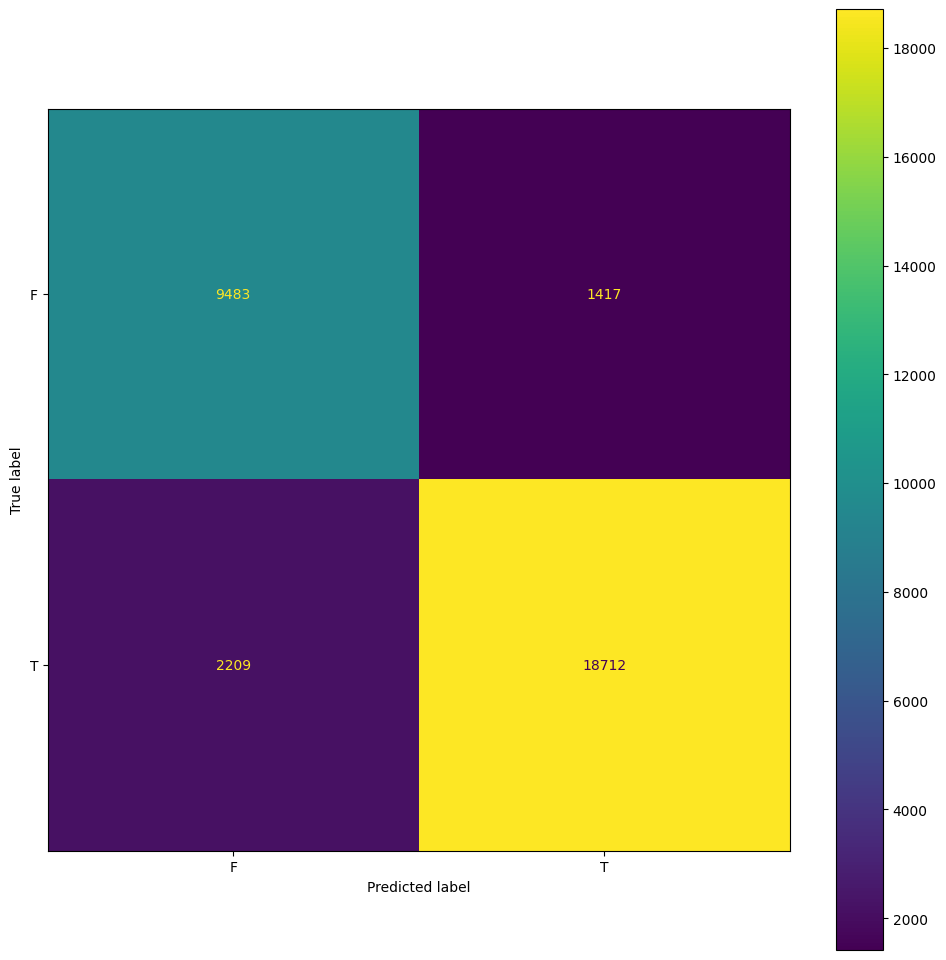

              precision    recall  f1-score   support

           F       0.81      0.87      0.84     10900
           T       0.93      0.89      0.91     20921

    accuracy                           0.89     31821
   macro avg       0.87      0.88      0.88     31821
weighted avg       0.89      0.89      0.89     31821



In [174]:
BaselineBinary('f_t')

### 3.4) Judging VS Perceiving

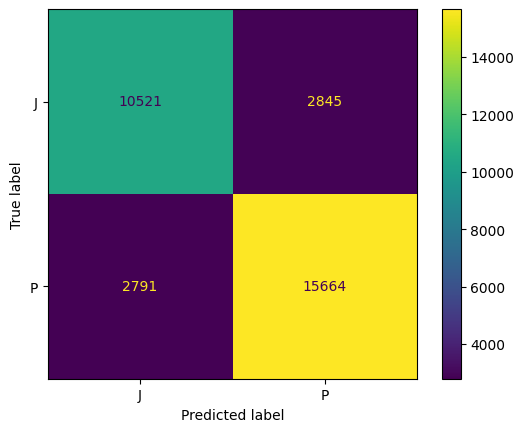

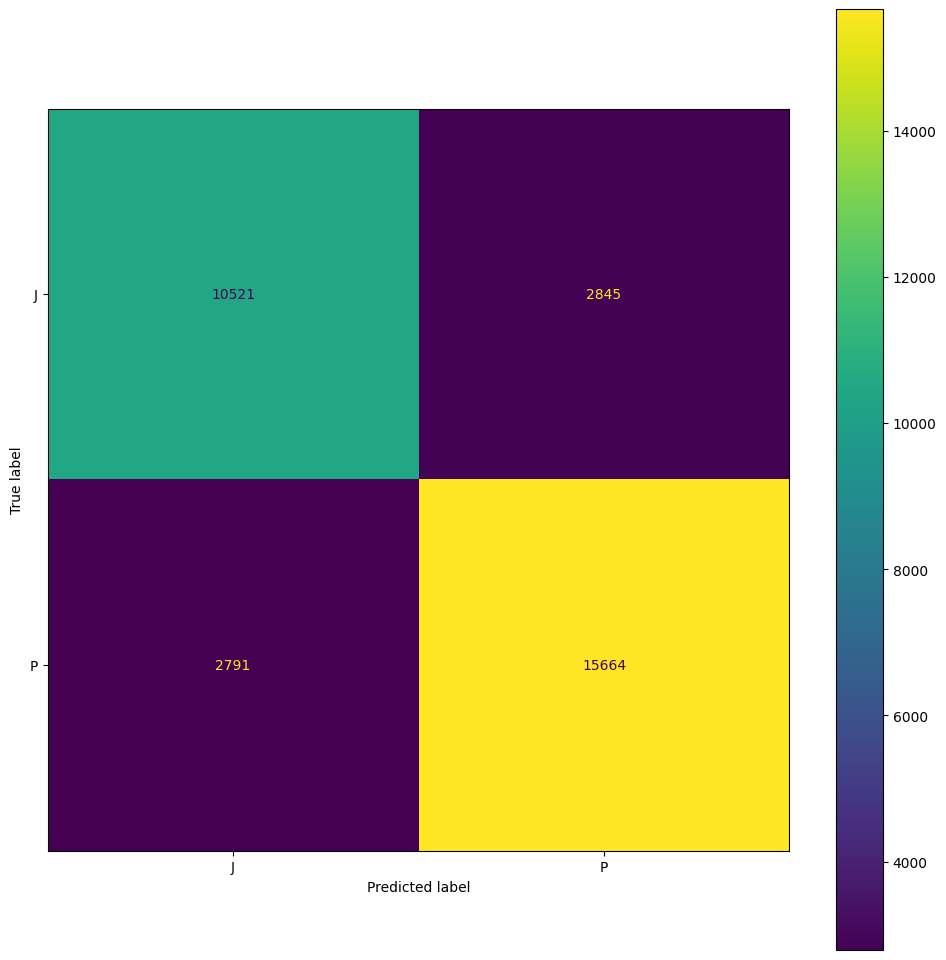

              precision    recall  f1-score   support

           J       0.79      0.79      0.79     13366
           P       0.85      0.85      0.85     18455

    accuracy                           0.82     31821
   macro avg       0.82      0.82      0.82     31821
weighted avg       0.82      0.82      0.82     31821



In [175]:
BaselineBinary('p_j')

## 4) Overall Results for Baselines

For our scoring, we will want to use a 'Macro' Average fo the F1-Score, as using a weighted average will always favor the larger classes.

In [176]:
MBTI_16_Score = .3

## 2nd Most Imbalanced
MBTI_E_Score = .59
MBTI_I_Score = .9
MBTI_EI_AVG = .74

## Most Imbalanced
MBTI_S_Score = .49
MBTI_N_Score = .97
MBTI_SN_AVG = .73

## 2nd Most Balanced
MBTI_F_Score = .84
MBTI_T_Score = .91
MBTI_FT_AVG = .88

## Most Balanced
MBTI_J_Score = .79
MBTI_P_Score = .85
MBTI_JP_AVG = .82

In [178]:
score_total = MBTI_EI_AVG + MBTI_SN_AVG + MBTI_FT_AVG + MBTI_JP_AVG
score_total/4

0.7925

## Baseline Score for 4 Binary Model Approach:
# 79.25% F1 